Loaded 1819 questions and 36 documents
Loaded 1819 questions

=== Questions DataFrame ===
   topic_id                                  uuid  \
0        22  cbc1c6c5-5352-4cbe-9e5b-325f2ddb9122   
1        24  26f7b66b-4a83-41d7-ba30-8f7025a83b43   
2        33  4e8417f1-1c8e-4c2e-9f32-5845c4742391   
3        33  4cb6e0ab-6dfc-4939-b73e-5724f27c2470   
4         5  c53136d0-7ebb-467c-b872-451c59dcc7e6   

                                        target_event  \
0  Iran launched ballistic missile attacks agains...   
1  World leaders, including Fumio Kishida, Joe Bi...   
2  French President Emmanuel Macron announced Fra...   
3  President Bolsonaro announced a 60-day ban on ...   
4                 Musk fired top Twitter executives.   

                                            option_A  \
0  On December 29, US forces conducted airstrikes...   
1  The U.S. State Department confirmed at least t...   
2  MAAP released a report revealing overlap betwe...   
3  MAAP released a report reve

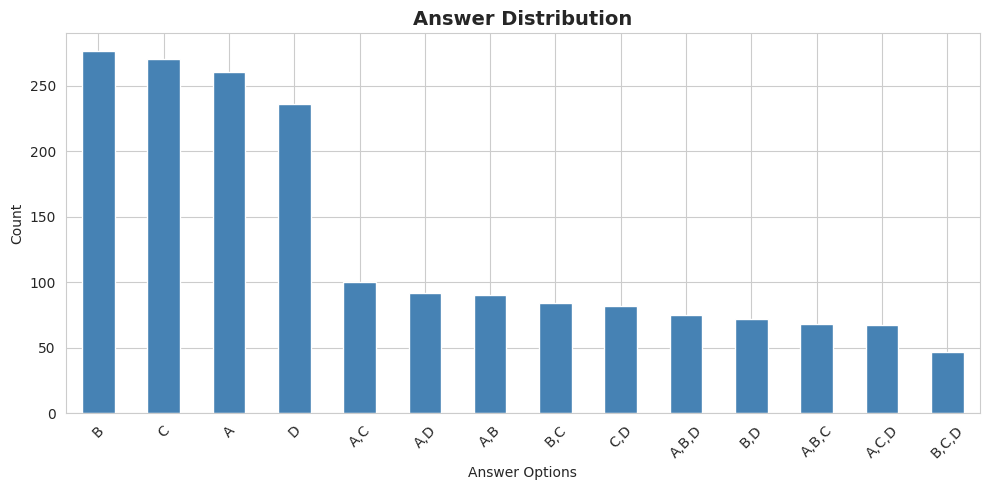

/tmp/ipython-input-3881787290.py:111: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


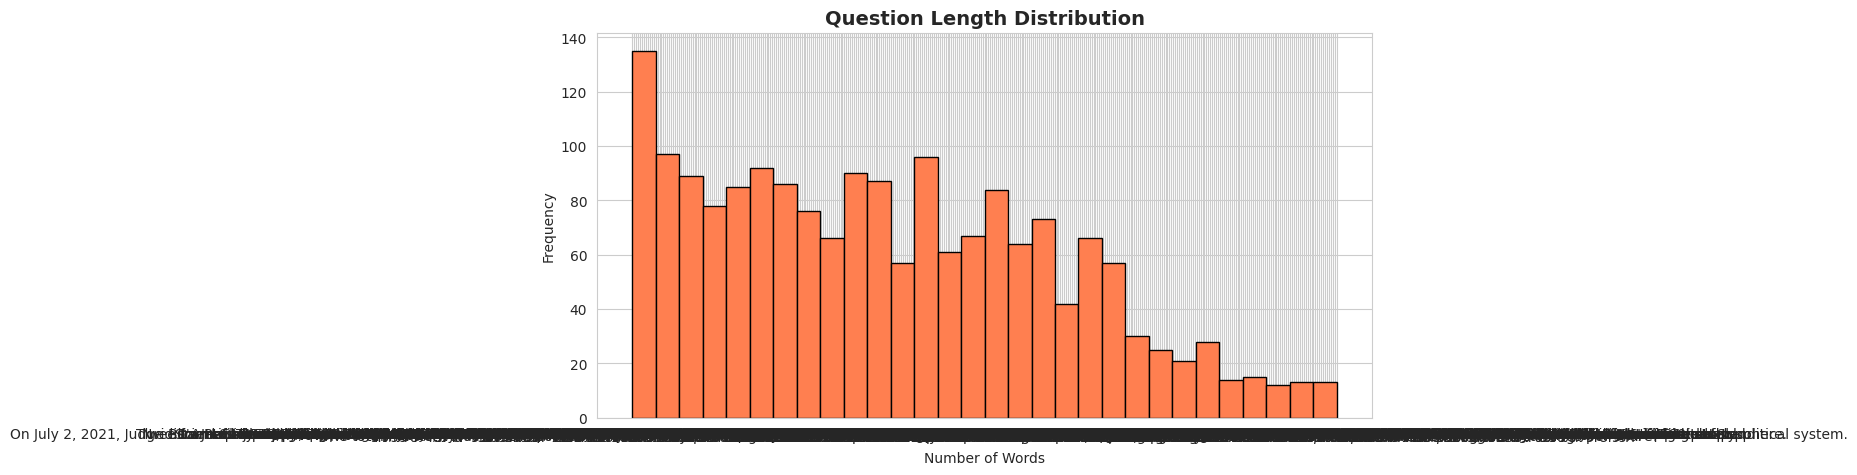

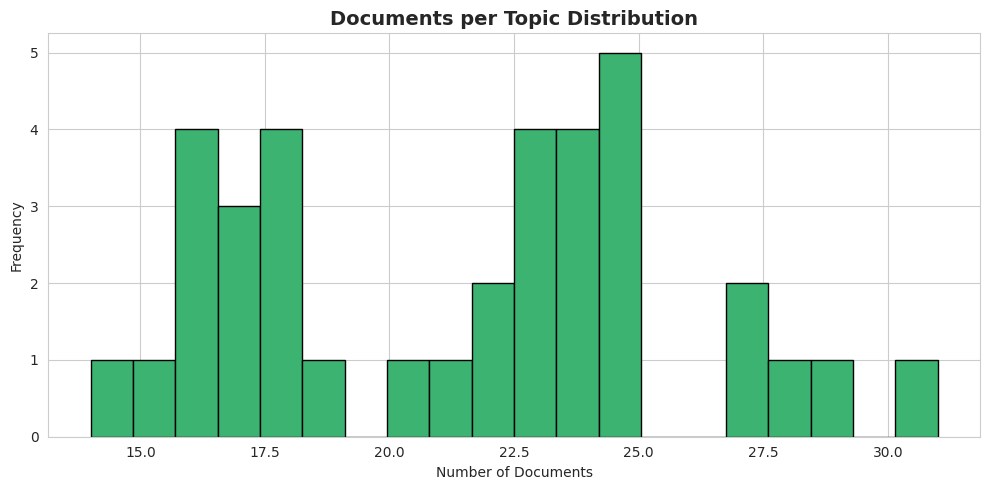


=== Preprocessed Data ===
   topic_id                                           question  \
0        22  Iran launched ballistic missile attacks agains...   
1        24  World leaders, including Fumio Kishida, Joe Bi...   
2        33  French President Emmanuel Macron announced Fra...   
3        33  President Bolsonaro announced a 60-day ban on ...   
4         5                 Musk fired top Twitter executives.   

                                            option_A  \
0  On December 29, US forces conducted airstrikes...   
1  The U.S. State Department confirmed at least t...   
2  MAAP released a report revealing overlap betwe...   
3  MAAP released a report revealing overlap betwe...   
4   Twitter sued Elon Musk to force the acquisition.   

                                            option_B  \
0     After 2006, Muhandis founded Kataib Hezbollah.   
1  At least 153 people were killed and dozens inj...   
2  The Brazilian government struggled to contain ...   
3             N

In [2]:

"""
Abductive Event Reasoning - Data Preprocessing and Exploratory Data Analysis
This notebook handles data loading, preprocessing, and initial analysis
"""

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. LOAD DATA

def load_jsonl(filepath):
    """Load JSONL file"""
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

# Load questions and documents
questions = load_jsonl(r'/content/dataset/question.jsonl')
# Load docs (normal JSON file)
with open(r'/content/dataset/docs.json', 'r', encoding='utf-8') as f:
    docs = json.load(f)

print(f"Loaded {len(questions)} questions and {len(docs)} documents")

print(f"Loaded {len(questions)} questions")

# 2. DATA EXPLORATION

# Convert to DataFrame for easier analysis
df_questions = pd.DataFrame(questions)
print("\n=== Questions DataFrame ===")
print(df_questions.head())
print(f"\nShape: {df_questions.shape}")
print(f"\nColumns: {df_questions.columns.tolist()}")


# Analyze answer distribution
answer_counts = Counter(df_questions['golden_answer'])
print("\n=== Answer Distribution ===")
for answer, count in sorted(answer_counts.items()):
    print(f"{answer}: {count}")


# Check for multi-label answers
multi_label = df_questions[df_questions['golden_answer'].str.contains(',')]
print(f"\n=== Multi-label instances: {len(multi_label)} ===")

# Analyze target_event lengths
df_questions['question_length'] = df_questions['target_event'].apply(lambda x: len(x.split()))
print("\n=== Question Length Statistics ===")
print(df_questions['question_length'].describe())

# Analyze option lengths
for opt in ['option_A', 'option_B', 'option_C', 'option_D']:
    df_questions[f'{opt}_length'] = df_questions[opt].apply(lambda x: len(x.split()))

print("\n=== Option Length Statistics ===")
for opt in ['option_A', 'option_B', 'option_C', 'option_D']:
    print(f"\n{opt}:")
    print(df_questions[f'{opt}_length'].describe())

# 3. DOCUMENT ANALYSIS

# Analyze document counts
doc_counts = []
total_doc_length = []

for doc_set in docs:
    doc_list = doc_set['docs']
    doc_counts.append(len(doc_list))
    total_length = sum([len(d.get('content', '').split()) for d in doc_list])
    total_doc_length.append(total_length)

print("\n=== Document Statistics ===")
print(f"Average docs per topic: {np.mean(doc_counts):.2f}")
print(f"Max docs: {np.max(doc_counts)}")
print(f"Min docs: {np.min(doc_counts)}")
print(f"Average total doc length: {np.mean(total_doc_length):.2f} words")

# 4. VISUALIZATION

# Plot answer distribution
plt.figure(figsize=(10, 5))
answer_series = df_questions['golden_answer'].value_counts()
answer_series.plot(kind='bar', color='steelblue')
plt.title('Answer Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Answer Options')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('answer_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot question length distribution
plt.figure(figsize=(10, 5))
plt.hist(df_questions['target_event'], bins=30, color='coral', edgecolor='black')
plt.title('Question Length Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('question_length_dist.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot document count distribution
plt.figure(figsize=(10, 5))
plt.hist(doc_counts, bins=20, color='mediumseagreen', edgecolor='black')
plt.title('Documents per Topic Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Number of Documents')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('doc_count_dist.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. DATA PREPROCESSING

def preprocess_text(text):
    """Clean and preprocess text"""
    if not isinstance(text, str):
        return ""

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove special characters but keep punctuation
    text = re.sub(r'[^\w\s.,!?;:\'-]', '', text)

    return text


# Merge questions with documents
merged_data = []

for q in questions:
    topic_id = q['topic_id']

    # Find corresponding documents
    topic_docs = next((d for d in docs if d['topic_id'] == topic_id), None)

    # Combine all document content
    if topic_docs and topic_docs['docs']:
        doc_text = " ".join([d.get('content', '') for d in topic_docs['docs']])
    else:
        doc_text = ""

    # Create merged record
    merged_record = {
        'topic_id': topic_id,
        'question': preprocess_text(q['target_event']),
        'option_A': preprocess_text(q['option_A']),
        'option_B': preprocess_text(q['option_B']),
        'option_C': preprocess_text(q['option_C']),
        'option_D': preprocess_text(q['option_D']),
        'context': preprocess_text(doc_text),
        'answer': q['golden_answer']
    }

    merged_data.append(merged_record)

# Create final DataFrame
df_final = pd.DataFrame(merged_data)

print("\n=== Preprocessed Data ===")
print(df_final.head())
print(f"\nShape: {df_final.shape}")

# Save preprocessed validation data as JSON
df_final.to_json('training_clean_data.json', orient='records', lines=True, force_ascii=False)
print("\n✅ Preprocessed validation data saved to '/content/artifacts/training_clean_data.json'")

# 6. LABEL ENCODING

# Convert answers to multi-label format
def encode_answer(answer):
    """Convert answer string to multi-hot encoding"""
    # A,B,C,D -> [1,1,1,1]
    options = ['A', 'B', 'C', 'D']
    encoding = [1 if opt in answer else 0 for opt in options]
    return encoding



df_final['label_encoding'] = df_final['answer'].apply(encode_answer)

# Separate features
print("\n=== Label Encoding Example ===")
print(df_final[['answer', 'label_encoding']].head())

# Save for model training
df_final.to_pickle('preprocessed_data.pkl')
print("\n✅ Preprocessed data with encodings saved to '//content/artifacts/preprocessed_data.pkl'\n")


"""
Validation Data Preprocessing Script
Creates validation.pkl with the same structure as preprocessed_data.pkl
"""
# 1. LOAD VALIDATION DATA

def load_jsonl(filepath, limit=None):
    """Load JSONL file with optional limit"""
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if limit and i >= limit:
                break
            data.append(json.loads(line.strip()))
    return data


# Load validation questions and documents
validation_questions = load_jsonl('/content/dataset/validation/questions.jsonl')
with open('/content/dataset/validation/docs.json', 'r', encoding='utf-8') as f:
    validation_docs = json.load(f)


print(f"Loaded {len(validation_questions)} validation questions")


# 2. TEXT PREPROCESSING FUNCTION

def preprocess_text(text):
    """Clean and preprocess text"""
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^\w\s.,!?;:\'-]', '', text)
    return text

# 3. MERGE QUESTIONS WITH DOCUMENTS

merged_data = []

for q in validation_questions:
    topic_id = q['topic_id']
    topic_docs = next((d for d in validation_docs if d['topic_id'] == topic_id), None)

    if topic_docs and topic_docs['docs']:
        doc_text = " ".join([d.get('content', '') for d in topic_docs['docs']])
    else:
        doc_text = ""

    merged_record = {
        'topic_id': topic_id,
        'question': preprocess_text(q['target_event']),
        'option_A': preprocess_text(q['option_A']),
        'option_B': preprocess_text(q['option_B']),
        'option_C': preprocess_text(q['option_C']),
        'option_D': preprocess_text(q['option_D']),
        'context': preprocess_text(doc_text),
        'answer': q['golden_answer']
    }
    merged_data.append(merged_record)

df_val = pd.DataFrame(merged_data)
print(f"\n✅ Validation dataset created with shape: {df_val.shape}")


# 4. ENCODE LABELS


def encode_answer(answer):
    """Convert answer string to multi-hot encoding"""
    options = ['A', 'B', 'C', 'D']
    encoding = [1 if opt in answer else 0 for opt in options]
    return encoding

df_val['label_encoding'] = df_val['answer'].apply(encode_answer)

print("\n=== Label Encoding Example ===")
print(df_val[['answer', 'label_encoding']].head())


# 5. SAVE AS PICKLE


df_val.to_pickle('validation_preprocessed.pkl')
print("✅ Validation data also saved as pickle file 'validation_preprocessed.pkl'")

print("PREPROCESSING COMPLETE!")
